In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import numpy as np

In [119]:
#Config
# Define custom colors for train methods (algorithms)
train_method_colors = {
    "ccka": "#1f77b4",  # Blue
    "random": "#ff7f0e",  # Orange
    "quack": "#2ca02c",  # Green
    "full": "#d62728"  # Red
}

algoritms = ['ccka', 'random', 'quack', 'full']
clusters = ['2', '4', '6', '8', '10']
bar_width = 0.4

In [120]:
path = 'results/runs'
exps = os.listdir(path)

dfs = []
for folder in exps:
    if folder != ".DS_Store":
        exp_folders = os.listdir(os.path.join(path, folder))
        for expsf in exp_folders:
            try:
                files = os.listdir(os.path.join(path, folder, expsf))
                file_path = os.path.join(path, folder, expsf, 'result.json')
                with open(file_path, "r") as f:
                    data = json.load(f)
                df = pd.json_normalize(data)
                dfs.append(df)
            except:
                "Not a folder"
results = pd.concat(dfs)
concat_names = ['config.name', 'config.n_qubits', 'config.ansatz', 'config.train_method', 'config.lambda_kao', 'config.lambda_co', 'config.clusters']
results['config_combined'] = results[concat_names].astype(str).agg(' | '.join, axis=1)

In [121]:
df_counts = results['config_combined'].value_counts().reset_index()
df_counts.columns = ['config_combined', 'count']

In [122]:
results_avg = results.groupby('config_combined')[['accuracy_train_init', 'accuracy_test_init', 'accuracy_train_final', 'accuracy_test_final']].mean().reset_index()
results_avg[concat_names] = results_avg['config_combined'].str.split(' \| ', expand=True)
results_avg = results_avg[concat_names + ['accuracy_train_init', 'accuracy_test_init', 'accuracy_train_final', 'accuracy_test_final']]
results_avg.to_csv('accuracy_results.csv')

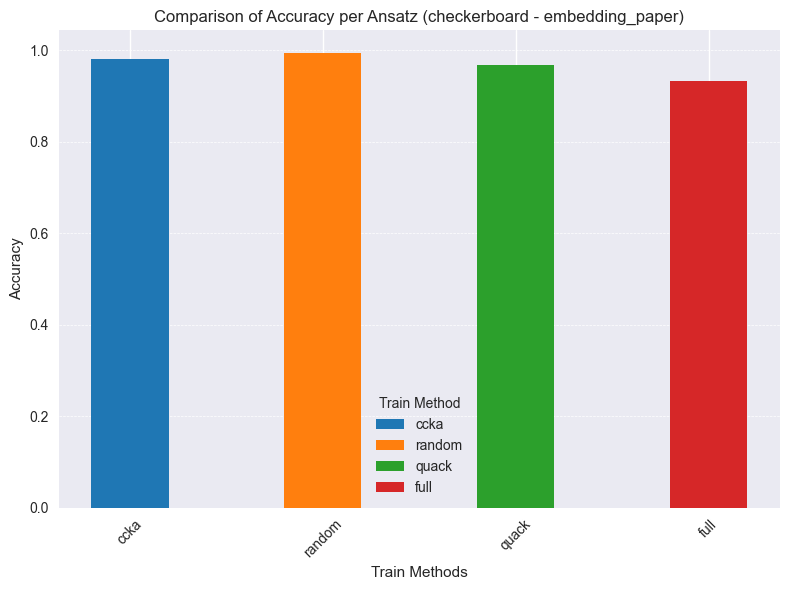

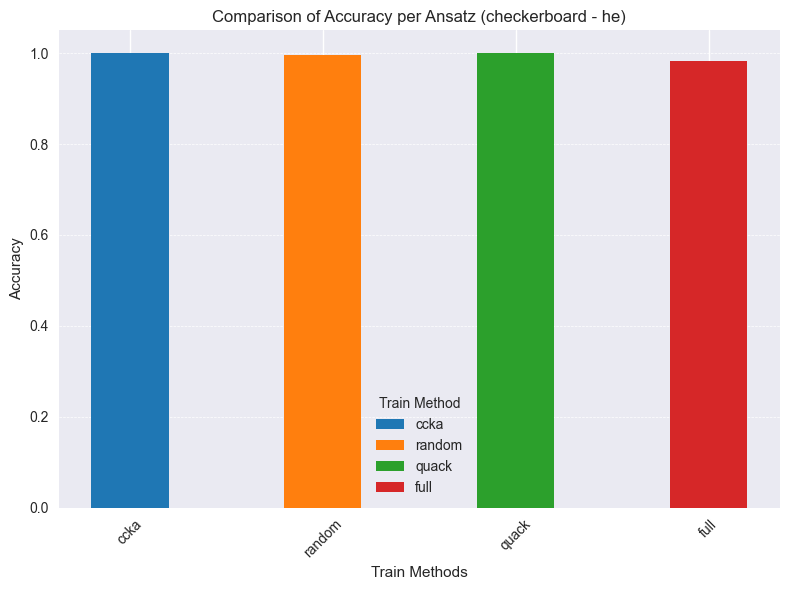

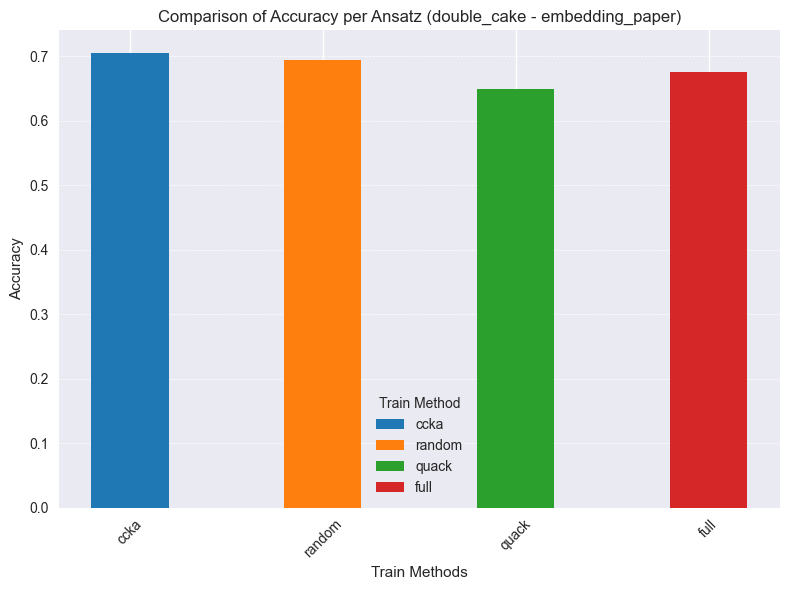

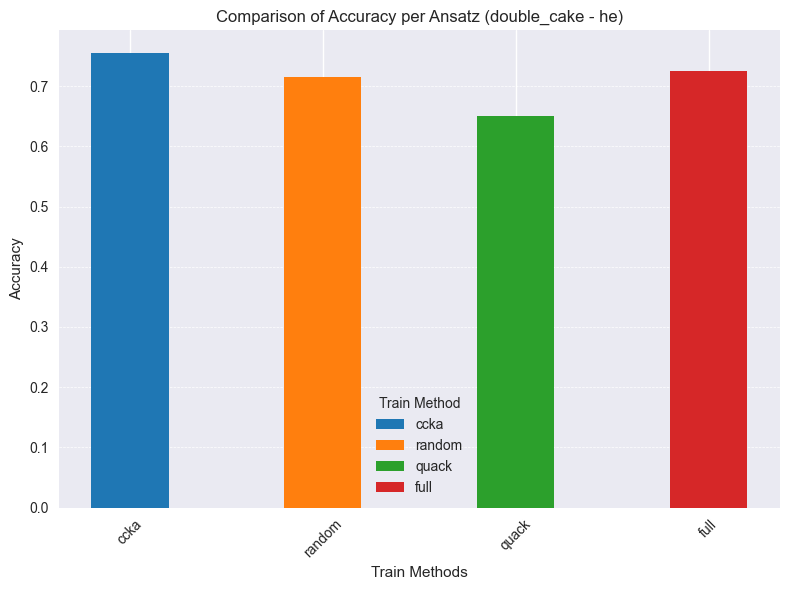

In [123]:
##Accuracy per ansatz 
results_per_ansatz = results_avg.groupby(['config.name','config.train_method', 'config.ansatz'])[['accuracy_train_init', 'accuracy_test_init', 'accuracy_train_final', 'accuracy_test_final']].mean().reset_index()
ansatzes = results_per_ansatz['config.ansatz'].unique().tolist()
datasets = results_per_ansatz['config.name'].unique().tolist()

# Fixing the error by dynamically adjusting the palette length
# Loop through datasets and ansatz types
for dataset in datasets:
    for ansatz in ansatzes:
        subset = results_per_ansatz[
            (results_per_ansatz["config.ansatz"] == ansatz) & 
            (results_per_ansatz["config.name"] == dataset)
        ]
        
        plt.style.use('seaborn-v0_8')
        plt.figure(figsize=(8, 6))

        # Generate x positions for bars
        x_pos = np.arange(len(subset["config.train_method"].unique()))

        # Loop through each training method and plot bars
        for i, method in enumerate(algoritms):
            method_data = subset[subset["config.train_method"] == method]
            plt.bar(x_pos[i], method_data["accuracy_test_final"].values[0], width=bar_width, color=train_method_colors[method], label=method)

        # Add labels, title, and legend
        plt.xlabel("Train Methods")
        plt.ylabel("Accuracy")
        plt.title(f"Comparison of Accuracy per Ansatz ({dataset} - {ansatz})")
        plt.xticks(x_pos, algoritms, rotation=45)
        plt.legend(title="Train Method")
        plt.grid(axis='y', linestyle='--', linewidth=0.5)

        # Display the plot
        plt.tight_layout()
        plt.show()

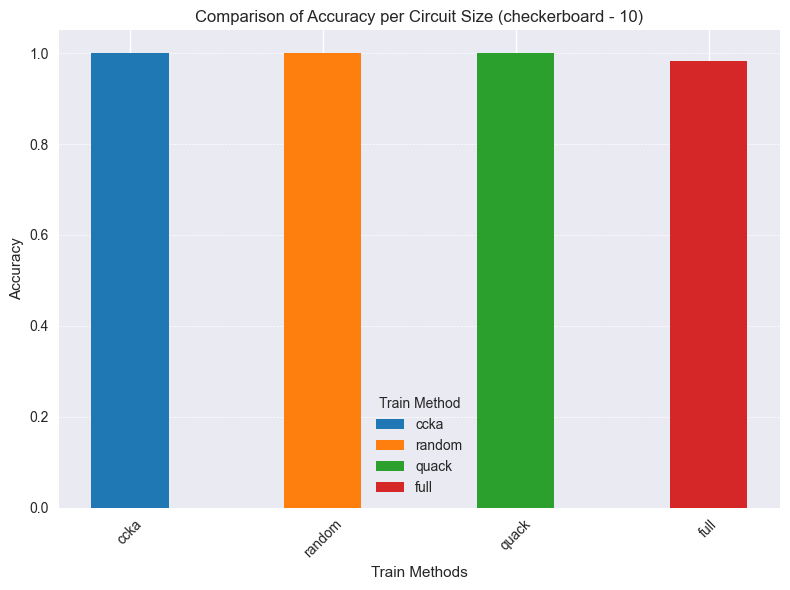

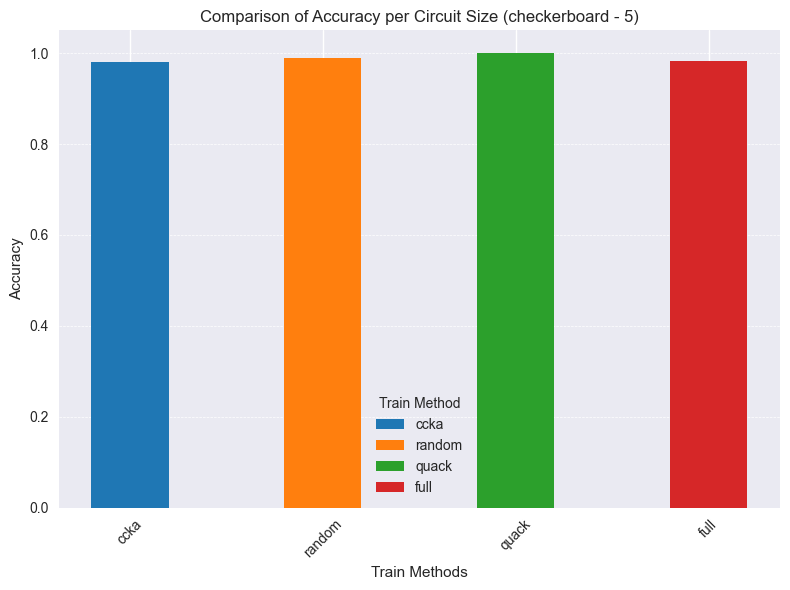

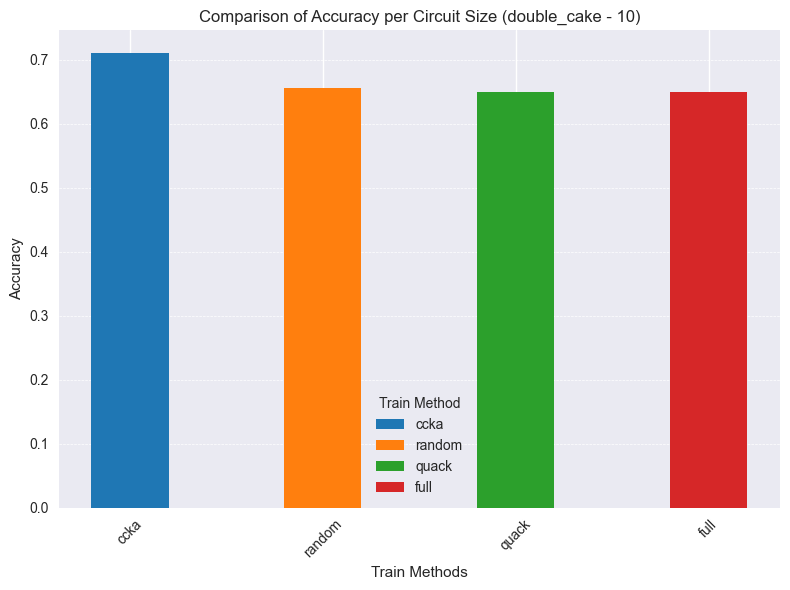

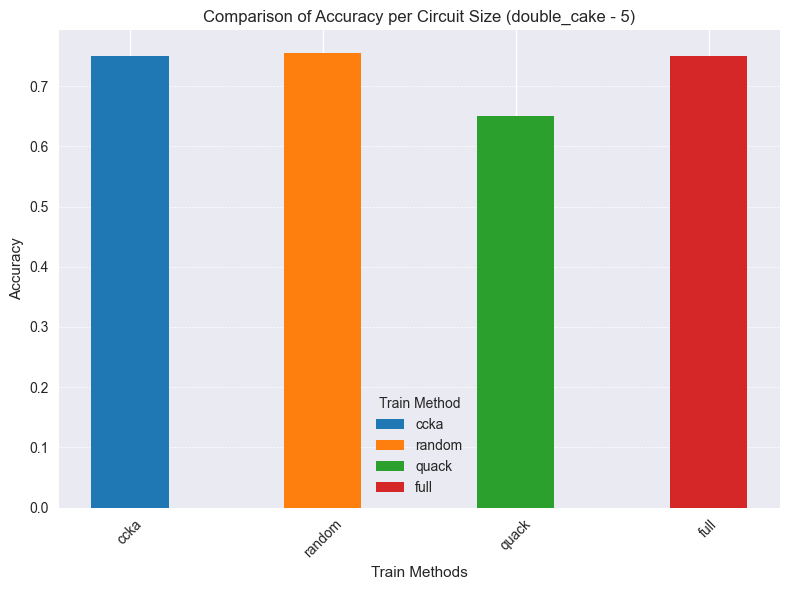

In [124]:
##accuracy per qubit number
results_per_qubits= results_avg.groupby(['config.name','config.train_method', 'config.n_qubits'])[['accuracy_train_init', 'accuracy_test_init', 'accuracy_train_final', 'accuracy_test_final']].mean().reset_index()
results_per_qubits = results_per_qubits.where(results_per_qubits['config.n_qubits'] != '2').dropna()
qubits = results_per_qubits['config.n_qubits'].unique().tolist()
datasets = results_per_qubits['config.name'].unique().tolist()

# Fixing the error by dynamically adjusting the palette length
# Loop through datasets and ansatz types
for dataset in datasets:
    for qubit in qubits:
        subset = results_per_qubits[
            (results_per_qubits["config.n_qubits"] == qubit) & 
            (results_per_qubits["config.name"] == dataset)
        ]
        
        plt.style.use('seaborn-v0_8')
        plt.figure(figsize=(8, 6))

        # Generate x positions for bars
        x_pos = np.arange(len(subset["config.train_method"].unique()))

        # Loop through each training method and plot bars
        for i, method in enumerate(algoritms):
            method_data = subset[subset["config.train_method"] == method]
            plt.bar(x_pos[i], method_data["accuracy_test_final"].values[0], width=bar_width, color=train_method_colors[method], label=method)

        # Add labels, title, and legend
        plt.xlabel("Train Methods")
        plt.ylabel("Accuracy")
        plt.title(f"Comparison of Accuracy per Circuit Size ({dataset} - {qubit})")
        plt.xticks(x_pos, algoritms, rotation=45)
        plt.legend(title="Train Method")
        plt.grid(axis='y', linestyle='--', linewidth=0.5)

        # Display the plot
        plt.tight_layout()
        plt.show()

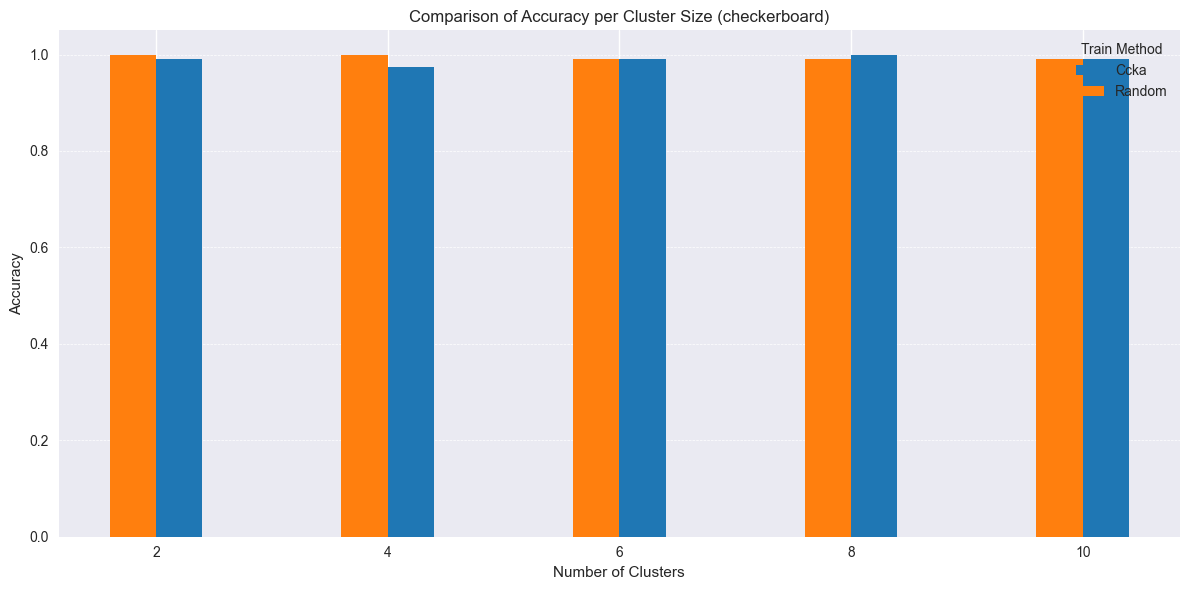

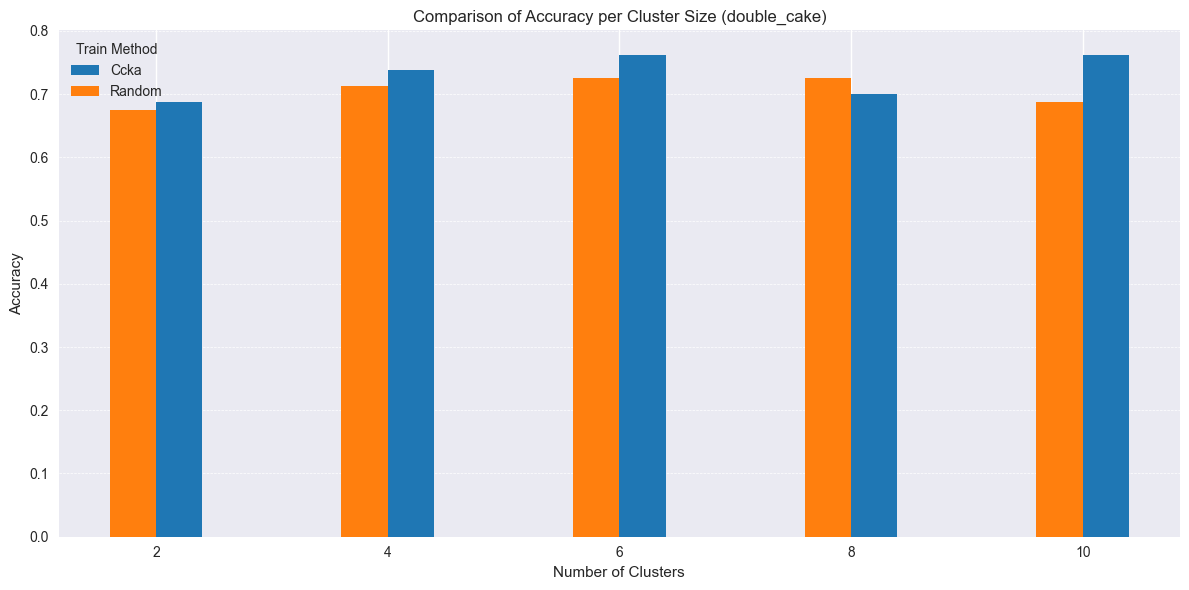

In [148]:
# Group by required columns and compute mean values
results_per = results_avg.groupby(['config.name', 'config.train_method', 'config.clusters'])[
    ['accuracy_train_init', 'accuracy_test_init', 'accuracy_train_final', 'accuracy_test_final']
].mean().reset_index()

# Modify cluster values for 'quack' and 'full' train methods
results_per.loc[results_per['config.train_method'] == 'quack', 'config.clusters'] = 'full'
results_per.loc[results_per['config.train_method'] == 'full', 'config.clusters'] = 'full'

results_per_clusters = results_per[~results_per['config.train_method'].isin(['full', 'quack'])]

# Get unique cluster sizes and datasets
datasets = results_per_clusters['config.name'].unique().tolist()


# Loop through datasets and plot accuracy per cluster
for dataset in datasets:
    subset = results_per_clusters[results_per_clusters["config.name"] == dataset]
    
    plt.style.use('seaborn-v0_8')
    plt.figure(figsize=(12, 6))

    # Get unique clusters for the current dataset
    cluster_indices = np.arange(len(clusters))  # Ensure the same length

    # Loop through each training method and plot bars
    for i, method in enumerate(["ccka", "random", "quack", "full"]):
        method_data = subset[subset["config.train_method"] == method]

        # Ensure that there is data to plot
        if not method_data.empty:
            plt.bar(
                cluster_indices - (i - 2.5) * bar_width, method_data["accuracy_test_final"], width=bar_width,
                label=method.capitalize(), color=train_method_colors[method]
            )

    # Add labels, title, and legend
    plt.xlabel("Number of Clusters")
    plt.ylabel("Accuracy")
    plt.title(f"Comparison of Accuracy per Cluster Size ({dataset})")
    plt.xticks(cluster_indices + (i - 1.0) * bar_width, clusters) 
    plt.legend(title="Train Method")
    plt.grid(axis='y', linestyle='--', linewidth=0.5)

    # Display the plot
    plt.tight_layout()
    plt.show()

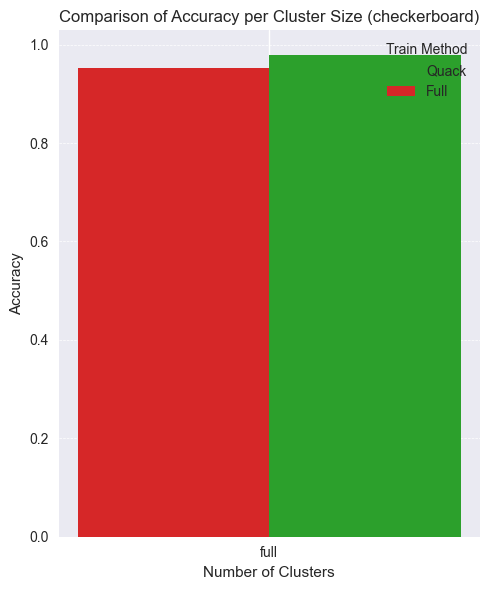

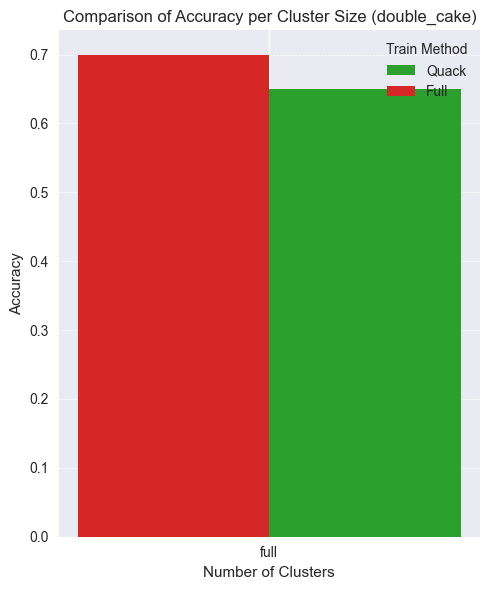

In [146]:
results_per_full = results_per[results_per['config.train_method'].isin(['full', 'quack'])]
# Get unique cluster sizes and datasets
datasets = results_per_full['config.name'].unique().tolist()

clusters_ = ['full']
# Loop through datasets and plot accuracy per cluster
for dataset in datasets:
    subset = results_per_full[results_per_full["config.name"] == dataset]
    
    plt.style.use('seaborn-v0_8')
    plt.figure(figsize=(5, 6))

    # Get unique clusters for the current dataset
    cluster_indices = np.arange(len(clusters_))  # Ensure the same length

    # Loop through each training method and plot bars
    for i, method in enumerate(["quack", "full"]):
        method_data = subset[subset["config.train_method"] == method]
        # Ensure that there is data to plot
        if not method_data.empty:
            plt.bar(
                cluster_indices - (i - 2.5) * bar_width, method_data["accuracy_test_final"], width=bar_width,
                label=method.capitalize(), color=train_method_colors[method]
            )

    # Add labels, title, and legend
    plt.xlabel("Number of Clusters")
    plt.ylabel("Accuracy")
    plt.title(f"Comparison of Accuracy per Cluster Size ({dataset})")
    plt.xticks(cluster_indices + 0.4, clusters_) 
    plt.legend(title="Train Method")
    plt.grid(axis='y', linestyle='--', linewidth=0.5)

    # Display the plot
    plt.tight_layout()
    plt.show()

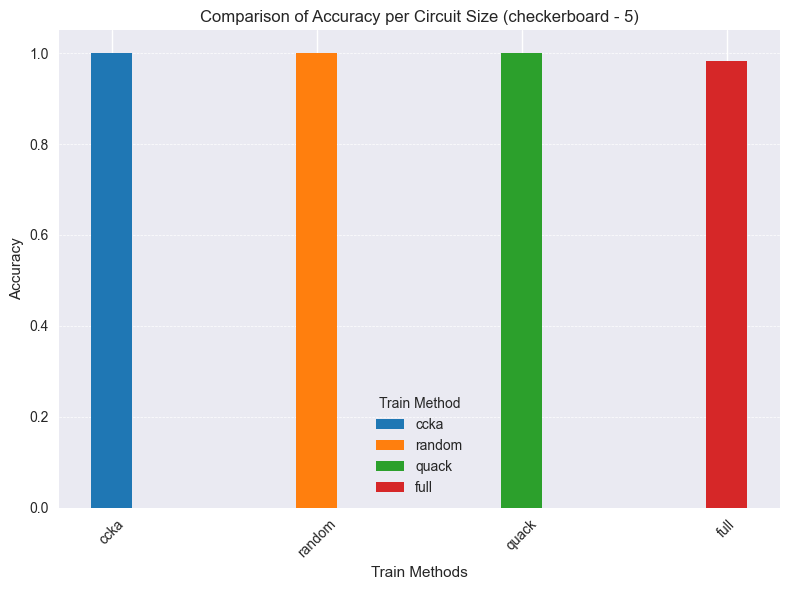

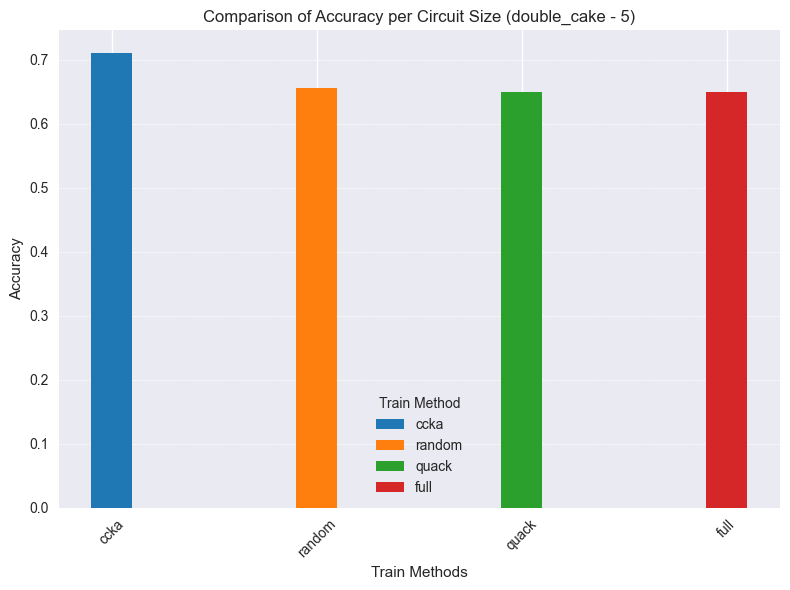

In [149]:
## Averaged Accuracy per algorithm 
##accuracy per qubit number
results_per_method = results_avg.groupby(['config.name','config.train_method'])[['accuracy_train_init', 'accuracy_test_init', 'accuracy_train_final', 'accuracy_test_final']].mean().reset_index()
datasets = results_per_qubits['config.name'].unique().tolist()

# Fixing the error by dynamically adjusting the palette length
# Loop through datasets and ansatz types
for dataset in datasets:
    subset = results_per_qubits[
          (results_per_qubits["config.name"] == dataset)
        ]
        
    plt.style.use('seaborn-v0_8')
    plt.figure(figsize=(8, 6))

    # Generate x positions for bars
    x_pos = np.arange(len(subset["config.train_method"].unique()))

    # Loop through each training method and plot bars
    for i, method in enumerate(algoritms):
        method_data = subset[subset["config.train_method"] == method]
        plt.bar(x_pos[i], method_data["accuracy_test_final"].values[0], width=bar_width, color=train_method_colors[method], label=method)

        # Add labels, title, and legend
    plt.xlabel("Train Methods")
    plt.ylabel("Accuracy")
    plt.title(f"Comparison of Accuracy per Circuit Size ({dataset} - {qubit})")
    plt.xticks(x_pos, algoritms, rotation=45)
    plt.legend(title="Train Method")
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
        # Display the plot
    plt.tight_layout()
    plt.show()